1) Import Packages

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
import category_encoders as ce
import xgboost as xgb
import matplotlib.pyplot as mpl
from random import randint, choice

2) Load data, and simplify/clean it. This includes: only selecting variables needed; encoding the species; dropping NaN data in both censuses; converting to numpy arrays; altering such that labels represent growth.

In [2]:
t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")

# simplify columns and column names
expected_labels = t2[['treeID', 'dbh']]
expected_labels = expected_labels.rename(columns={"dbh": "dbh2", "treeID": "treeID2"})
featurest1 = t1[['treeID', 'sp', 'dbh']]
featurest1 = featurest1.rename(columns={"dbh": "dbh1", "treeID":"treeID1"})

# encode the species into binary features and drop rows with any NaN values
encoder= ce.BinaryEncoder(cols=['sp'],return_df=True)
featurest1 = encoder.fit_transform(featurest1)

df_combined = pd.concat([featurest1, expected_labels], axis=1)
df_combined_clean = df_combined.dropna()

# split back up and convert the dataframes to numpy arrays
df_clean = df_combined_clean[featurest1.columns]
labels_clean = df_combined_clean[expected_labels.columns]

featurest1 = df_clean.to_numpy()
expected_labels = labels_clean.to_numpy()

featurest1 = featurest1.astype(np.float32)
expected_labels = expected_labels.astype(np.float32)

# ensure that there is only positive growth, represented by CHANGE (not total dbh)
expected_labels[:,1] = expected_labels[:,1] - featurest1[:,10]
expected_labels = np.where (expected_labels<0, 0, expected_labels)

# change from numpy using round and then multiply by 5 (np a round)
#featurest1[:,10] = np.around(featurest1[:,10]/5)* 5

/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_23193/4122659635.py:1: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_23193/4122659635.py:2: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")


3) Do a hyperparameter search to determine the best settings for our random forest model.

In [3]:
# HYPERPARAMETER SEARCH
n_estimators = np.arange(100,400,100)
max_depth = [6,7, 8]
random_grid = {'max_depth': max_depth}
rf = RandomForestRegressor()
rf_grid = GridSearchCV(rf, param_grid= random_grid, scoring='r2', cv=5 )
rf_grid.fit(featurest1[:,1:], expected_labels[:,1])
rf_grid.best_params_


{'max_depth': 8}

4) Using these hyperparameters, train a Random Forest Regressor on ALL of the census data. Print the r2 error.

In [4]:
# trained on ALL of the data from 1985 to 1990
rf = RandomForestRegressor(max_depth = 8, n_estimators=100)
rf.fit(featurest1[:,1:], expected_labels[:,1])
preds = rf.predict(featurest1[:,1:])
error1a = r2_score(expected_labels[:,1], preds)
print (error1a)

# xg = xgb.XGBRegressor()
# xg.fit(featurest1[:,1:], expected_labels[:,1])

0.28163573487420934


5) Use K-Folds Cross Validation to further check the validity of this model.

In [5]:
cv = KFold(n_splits=5)
scores = cross_validate(rf, featurest1[:,1:], expected_labels[:,1], scoring=('neg_root_mean_squared_error','r2'), cv=cv)
print(scores)

{'fit_time': array([ 8.94319201,  8.88640785,  9.27584887, 12.60443807, 11.68639421]), 'score_time': array([0.24464607, 0.21140718, 0.20935917, 0.19954491, 0.18945479]), 'test_neg_root_mean_squared_error': array([-19.32171677,  -6.74400984,  -7.24409451,  -8.47478392,
        -8.64894571]), 'test_r2': array([0.07887462, 0.14564571, 0.18800479, 0.1587957 , 0.10947385])}


6) Create a list of all species, according to which ones are seen most frequently (sorted by decreasing abundance).

In [6]:
names = encoder.inverse_transform(featurest1)
sp_list = names.sp.unique()
sp_freq = names.sp.value_counts(sort=True).index.tolist()
sp_num = sp_list.shape[0]
sp_mat = np.hstack((np.atleast_2d(sp_list).transpose(), (np.zeros((sp_num, 9)))))

7) "Hallucinate" data for each species, creating a matrix where the species is represented with every DBH from 10 to 500 (every 5 mm). Add each of these to a list so that it can be easily indexed later on.

In [7]:
all_dbhs = np.arange(10,501,5).transpose()
all_dbhs_big = np.arange(10,501,5).transpose()
list_of_all_sp = []

for i in range(sp_num):
    # 1) look at initial dataset and find the tree with that ID, then find its encoding

    # find tree ID of one instance of a species
    tree_id = names[names.sp == sp_freq[i]].treeID1
    one_tree_id = tree_id.iloc[0]
    encoding = featurest1[featurest1[:,0]==one_tree_id][:,1:10]

    sp_label = np.atleast_2d(encoding)
    sp_repeated = np.repeat(sp_label,99,axis=0)
    sp_i = np.column_stack((sp_repeated,all_dbhs))
    all_dbhs_big = np.vstack((all_dbhs_big, all_dbhs))
    list_of_all_sp.append(sp_i)

In [8]:
one_big_array = np.vstack(list_of_all_sp)
all_dbhs_big = (all_dbhs_big.flatten())[:29106]

8) Create the predictions for each of these species and also add these to a list, for easy indexing.

In [9]:
list_of_all_preds = []
for sp in list_of_all_sp:
    preds = rf.predict(sp)
    list_of_all_preds.append(preds)

9) Plot the 4 most abundant species' predictions.

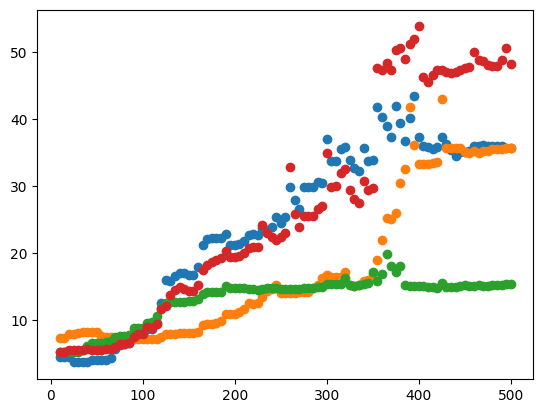

In [10]:
mpl.scatter(all_dbhs,list_of_all_preds[0], label = "Dataset"+str(0))
mpl.scatter(all_dbhs,list_of_all_preds[1], label = "Dataset"+str(1))
mpl.scatter(all_dbhs,list_of_all_preds[2], label = "Dataset"+str(2))
mpl.scatter(all_dbhs,list_of_all_preds[3], label = "Dataset"+str(3))

**New Idea**: Create a new model, ignoring species. Here, we can begin to create a model where species is encoded more strategically/hierarchechally: where genus is represented, and so is family.

1) Load data similarly, just without species.

In [16]:
t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")

# simplify columns and column names
expected_labels = t2[['treeID', 'dbh']]
expected_labels = expected_labels.rename(columns={"dbh": "dbh2", "treeID": "treeID2"})
featurest1 = t1[['treeID', 'dbh']]
featurest1 = featurest1.rename(columns={"dbh": "dbh1", "treeID":"treeID1"})

df_combined = pd.concat([featurest1, expected_labels], axis=1)
df_combined_clean = df_combined.dropna()

# split back up and convert the dataframes to numpy arrays
df_clean = df_combined_clean[featurest1.columns]
labels_clean = df_combined_clean[expected_labels.columns]

# NEW CODE HEREEE!!!!
def round_dbh(num): 
    return 5 * round(num/5)

df_clean.dbh1 = df_clean.dbh1.apply(round_dbh)

featurest1 = df_clean.to_numpy()
expected_labels = labels_clean.to_numpy()

featurest1 = featurest1.astype(np.float32)
expected_labels = expected_labels.astype(np.float32)

# ensure that there is only positive growth, represented by CHANGE (not total dbh)
expected_labels[:,1] = expected_labels[:,1] - featurest1[:,1]
expected_labels = np.where (expected_labels<0, 0, expected_labels)

/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_23193/1388651575.py:1: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_23193/1388651575.py:2: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_23193/1388651575.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.dbh1 = df_clean.dbh1.apply(round_dbh)


2) Train the models on the new data (without species).

In [17]:
rf2 = RandomForestRegressor()
rf2.fit(featurest1[:,1:], expected_labels[:,1])

xg2 = xgb.XGBRegressor()
xg2.fit(featurest1[:,1:], expected_labels[:,1])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

3) Predict the growth using this model.

In [18]:
all_dbhs = all_dbhs.reshape(-1, 1)
predictions_no_sp = rf2.predict(all_dbhs)

4) Plot this relationship.

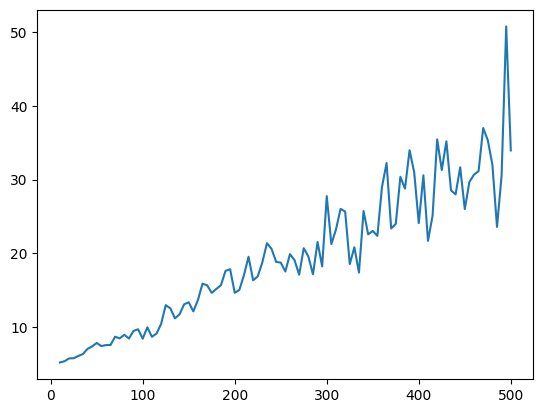

In [19]:
mpl.plot(all_dbhs, predictions_no_sp)

5) Measure the error in this model and compare it to that that DOES include species.

In [20]:
cv = KFold(n_splits=5)
scores = cross_validate(rf2, featurest1[:,1:], expected_labels[:,1], scoring=('neg_root_mean_squared_error','r2'), cv=cv)
print(scores)

{'fit_time': array([1.77518487, 1.82507682, 1.98137093, 2.04129887, 1.87277389]), 'score_time': array([0.16483808, 0.16615891, 0.15063691, 0.15198517, 0.0961802 ]), 'test_neg_root_mean_squared_error': array([-20.88675057,  -7.14005098,  -7.82249387,  -9.01513797,
        -9.05185524]), 'test_r2': array([-0.07553769,  0.04372301,  0.0554782 ,  0.04806858,  0.02617385])}


### Analysis ###
The r2 values for the model including species are overall more accurate, though have a bit more variance.